# Setup

In [95]:
import sys
import os
# add parent directory (where "natsume" lives) to sys.path so I can import natsume
sys.path.append(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME")
import natsume

import ttv_curvefit.curvefit as ttvfit  # custom-written
import ttvfast
from ttvfast import models

from tqdm import tqdm
import pandas as pd
import numpy as np
from scipy.stats import gmean
from astropy import units as u
from astropy.constants import M_earth
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

# Import CSV for fits
fits = pd.read_csv(r"C:\Users\WBS\Desktop\EXOPLANET WORK\006 NATSUME\validation\1st_order_TTVFast\lithwick_TTVFast_fits.csv")
total = len(fits)

R2_threshold = 0.5
R2_filter = (fits.R2_1 > R2_threshold) & (fits.R2_2 > R2_threshold)
fits = fits[R2_filter].reset_index()
good = len(fits)

print(f'Good systems: {good}/{total} ({(good/total) * 100:.2f}%)')

fits.head()

Good systems: 3748/15000 (24.99%)


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,V1,Pttv1,phase1,A2,B2,V2,Pttv2,phase2,R2_1,R2_2
0,2,0.001231,18.064109,0.002705,22.154587,-0.026507,2,7,13.628900,674.637818,...,0.708572,228.435939,1.760790,0.063622,-4.535777e-04,1.013388,227.953873,4.870417,0.947910,0.982851
1,7,0.042033,36.776952,0.001410,82.918436,0.054153,2,7,14.758149,62.870993,...,0.001233,139.604087,2.127186,-0.000879,2.826115e-06,0.014181,139.515198,5.423775,0.996469,0.997273
2,12,0.003260,74.828570,0.011135,61.329949,-0.028928,4,7,9.063341,3.087786,...,0.003447,78.648225,1.355034,-0.000578,1.126581e-06,0.001215,78.882690,4.549996,0.552683,0.634689
3,18,0.065756,82.884789,0.016307,3.628461,0.031656,3,7,10.832389,0.376612,...,0.004663,114.440403,0.454553,0.000002,8.247118e-09,0.000258,114.786614,3.578686,0.963919,0.974965
4,19,0.006460,64.978949,0.070559,62.393698,-0.093139,2,7,12.696060,344.344045,...,0.006449,68.240533,5.344276,0.010188,-6.383620e-06,0.021911,67.962702,2.680566,0.761729,0.600426


In [100]:
# Functions, returns in %
def err_gmean(calc, sol):
    gavg = gmean(calc/sol)
    return (gavg - 1) * 100

def err_med(calc, sol):
    gavg = np.median(calc/sol)
    return (gavg - 1) * 100

def err_gstd(calc, sol):
    logs = np.log(calc/sol)
    gstd = np.exp(logs.std(ddof=0))
    return gstd * 100

def returnMetrics(df, mask='all'):
    if isinstance(mask, str):
        if (mask == 'all'):
            m = np.ones(len(df), dtype=bool)
    else:
        m = mask
        
    err1 = err_gmean(df['m_calc_in'][m], df['m1'][m])
    err2 = err_gmean(df['m_calc_out'][m], df['m2'][m])
    med1 = err_med(df['m_calc_in'][m], df['m1'][m])
    med2 = err_med(df['m_calc_out'][m], df['m2'][m])
    gstd1 = err_gstd(df['m_calc_in'][m], df['m1'][m])
    gstd2 = err_gstd(df['m_calc_out'][m], df['m2'][m])

    return err1, err2, med1, med2, gstd1, gstd2

# Non-nominal validation

In [3]:
# Naive validation
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = fits['Pttv1']; PTTV_out = fits['Pttv2']
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities(e1[i], w1[i], e2[i], w2[i]) for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare = fits.copy()
compare['m_calc_in'] = mcalc_in
compare['m_calc_out'] = mcalc_out
compare['m_bad_in'] = mbad_in
compare['m_bad_out'] = mbad_out
compare.head()

100%|██████████████████████████████████████████████████████████████████████████████| 3748/3748 [00:37<00:00, 99.67it/s]


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,B2,V2,Pttv2,phase2,R2_1,R2_2,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,2,0.001231,18.064109,0.002705,22.154587,-0.026507,2,7,13.628900,674.637818,...,-4.535777e-04,1.013388,227.953873,4.870417,0.947910,0.982851,9701.072607,4006.955908,11903.082504,4646.814437
1,7,0.042033,36.776952,0.001410,82.918436,0.054153,2,7,14.758149,62.870993,...,2.826115e-06,0.014181,139.515198,5.423775,0.996469,0.997273,68.085633,6.854659,91.450850,13.817926
2,12,0.003260,74.828570,0.011135,61.329949,-0.028928,4,7,9.063341,3.087786,...,1.126581e-06,0.001215,78.882690,4.549996,0.552683,0.634689,3.402799,12.489443,6.421939,27.208986
3,18,0.065756,82.884789,0.016307,3.628461,0.031656,3,7,10.832389,0.376612,...,8.247118e-09,0.000258,114.786614,3.578686,0.963919,0.974965,0.408607,10.176591,0.299051,6.765545
4,19,0.006460,64.978949,0.070559,62.393698,-0.093139,2,7,12.696060,344.344045,...,-6.383620e-06,0.021911,67.962702,2.680566,0.761729,0.600426,317.326037,79.499741,1398.804668,189.397033


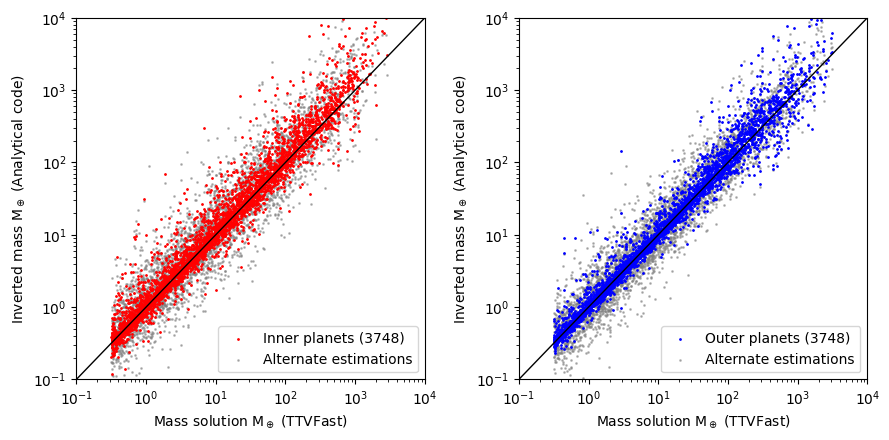

In [33]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(9, 4.5))  # 1 row, 2 columns
s = 1
minval = 1e-1
maxval = 1e+4
scatterCount = len(compare['m1'])

# Inner planets
ax[0].scatter(compare['m1'], compare['m_calc_in'], s=s, color='red', label=f'Inner planets ({scatterCount})', zorder=0)
ax[0].scatter(compare['m1'], compare['m_bad_in'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[0].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planets
ax[1].scatter(compare['m2'], compare['m_calc_out'], s=s, color='blue', label=f'Outer planets ({scatterCount})', zorder=0)
ax[1].scatter(compare['m2'], compare['m_bad_out'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[1].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

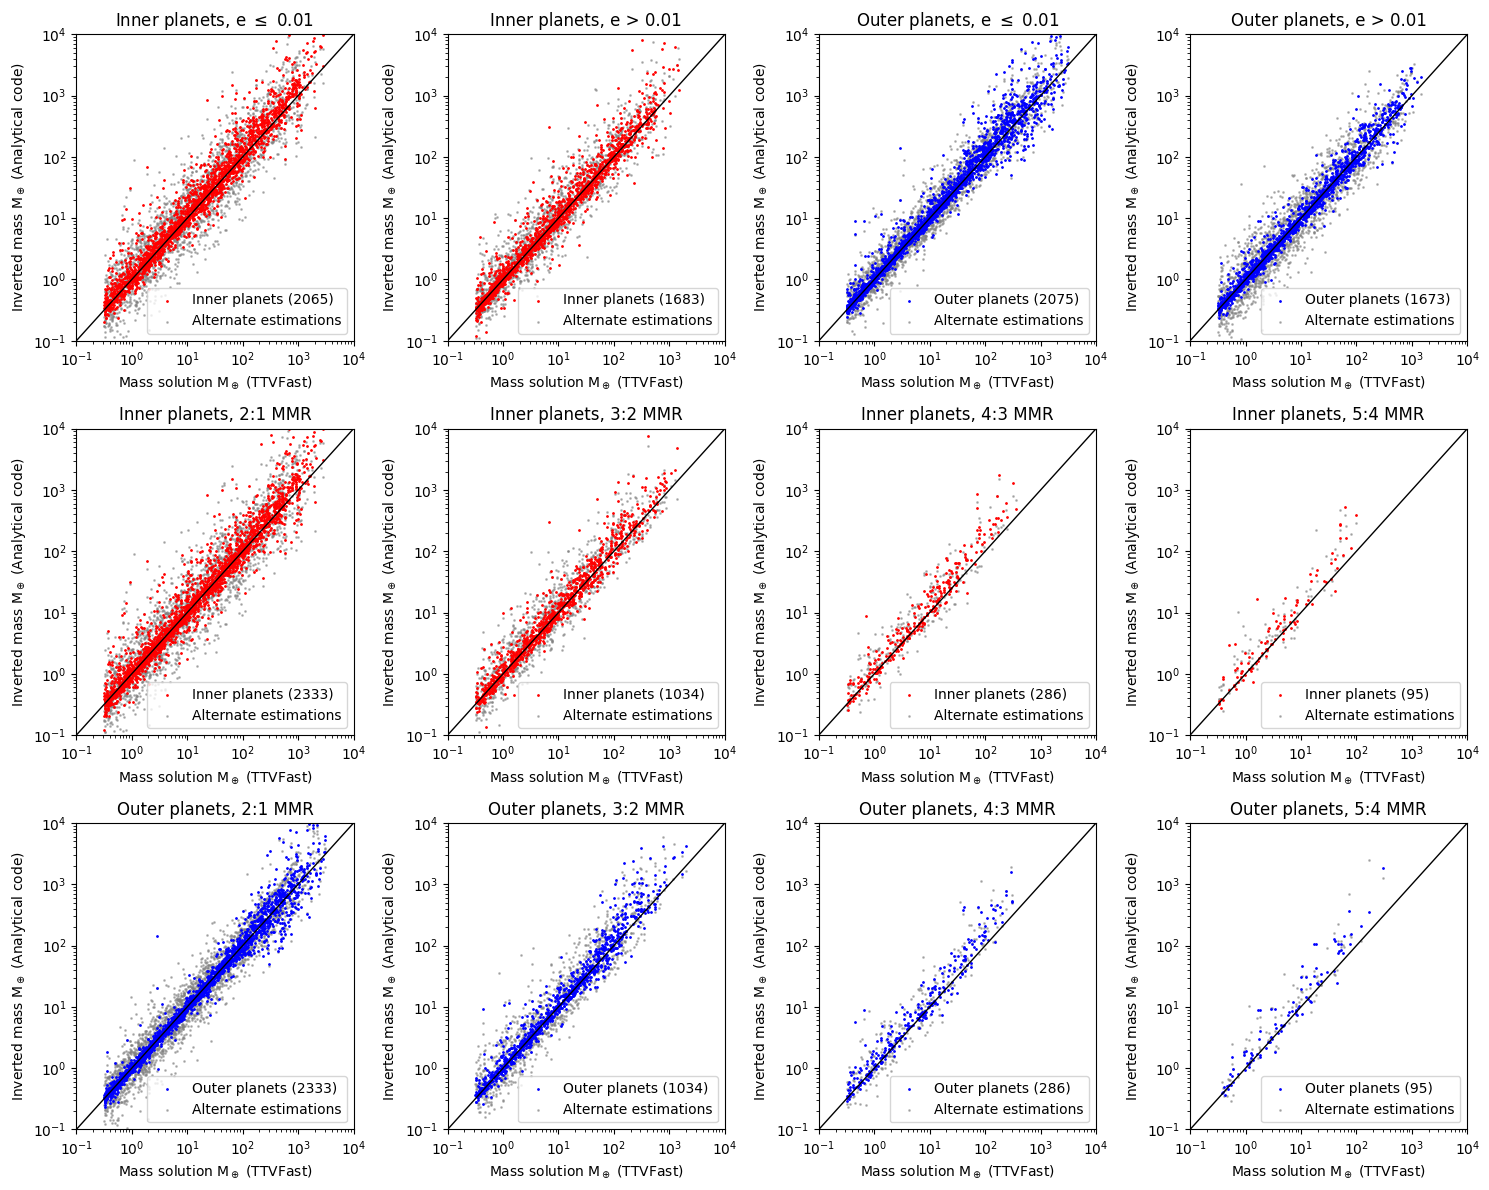

In [56]:
# Divide up by eccentricity and MMR
# Graph compare N-body outputs
fig, ax = plt.subplots(3, 4, figsize=(15, 12))

def plotMassEstimation(posTuple, x, ygood, ybad, color, innerouterStr, mask, regimeName):
    s = 1
    minval = 1e-1
    maxval = 1e+4
    scatterCount = len(x[mask])
    
    ax[posTuple].scatter(x[mask], ygood[mask], s=s, color=color, label=f'{innerouterStr} planets ({scatterCount})', zorder=0)
    ax[posTuple].scatter(x[mask], ybad[mask], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
    ax[posTuple].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
    ax[posTuple].set_xscale('log'); ax[posTuple].set_yscale('log')
    ax[posTuple].set_xlim(minval, maxval); ax[posTuple].set_ylim(minval, maxval)
    ax[posTuple].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
    ax[posTuple].set_ylabel('Inverted mass M$_\oplus$ (Analytical code)')
    ax[posTuple].legend(loc='lower right')
    ax[posTuple].set_title(f'{innerouterStr} planets, {regimeName}')

def plotMassWithRegimes(df):
    # Regime definitions
    ethres = 0.01
    lowe1 = (compare.e1 <= ethres); highe1 = (compare.e1 > ethres)
    lowe2 = (compare.e2 <= ethres); highe2 = (compare.e2 > ethres)
    def jmask(n): 
        return (compare.j == n)
    
    # Eccentricity
    plotMassEstimation((0,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', lowe1, 'e $\leq$ 0.01')
    plotMassEstimation((0,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', highe1, 'e > 0.01')
    plotMassEstimation((0,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', lowe2, 'e $\leq$ 0.01')
    plotMassEstimation((0,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', highe2, 'e > 0.01')
    
    # MMR
    plotMassEstimation((1,0), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(2), '2:1 MMR')
    plotMassEstimation((1,1), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(3), '3:2 MMR')
    plotMassEstimation((1,2), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(4), '4:3 MMR')
    plotMassEstimation((1,3), df['m1'], df['m_calc_in'], df['m_bad_in'], 'red', 'Inner', jmask(5), '5:4 MMR')
    
    plotMassEstimation((2,0), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(2), '2:1 MMR')
    plotMassEstimation((2,1), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(3), '3:2 MMR')
    plotMassEstimation((2,2), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(4), '4:3 MMR')
    plotMassEstimation((2,3), df['m2'], df['m_calc_out'], df['m_bad_out'], 'blue', 'Outer', jmask(5), '5:4 MMR')

plotMassWithRegimes(compare)

fig.tight_layout()
plt.show()

In [90]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.2f}%, {med1:.2f}%, {gstd1:.2f}%')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.2f}%, {med2:.2f}%, {gstd2:.2f}%')

Geometric mean error, median error, and geometric STD (Inner): 19.67%, 8.30%, 168.24%
Geometric mean error, median error, and geometric STD (Outer): 11.89%, 4.34%, 152.81%


# Nominal validation

In [52]:
# Naive nominal mass validation
j = fits['j']; mmr = j.apply(lambda x: f"{int(x)}:{int(x)-1}")
P_in = fits['P1']; P_out = fits['P2']
PTTV_in = fits['Pttv1']; PTTV_out = fits['Pttv2']
V_in = np.abs(fits['V1']); V_out = np.abs(fits['V2'])
Mstar = 1

e1 = fits['e1']; w1 = fits['w1']
e2 = fits['e2']; w2 = fits['w2']
z = [natsume.get_ComplexEccentricities() for i in range(len(e1))]

mu_in_sol = (fits['m1'].values * M_earth).to(Mstar*u.M_sun).value
mu_out_sol = (fits['m2'].values * M_earth).to(Mstar*u.M_sun).value

# Extract mu_out and mu_in
mcalc_out, mcalc_in = np.array([]), np.array([])
mbad_out, mbad_in = np.array([]), np.array([])
for i in tqdm(range(len(mmr))):
    TTV_in = natsume.get_TTVSineCurve(amplitude=V_in[i], superperiod=PTTV_in[i])
    TTV_out = natsume.get_TTVSineCurve(amplitude=V_out[i], superperiod=PTTV_out[i])

    mu_in = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i], eccentricity=z[i])
    mu_out = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i], eccentricity=z[i])

    mu_in_expected = natsume.EstimateInnerMass(outerTTV=TTV_out, outer_period=P_out[i], mmr=mmr[i],
                                               eccentricity=z[i], inner_period=P_in[i])
    mu_out_expected = natsume.EstimateOuterMass(innerTTV=TTV_in, inner_period=P_in[i], mmr=mmr[i],
                                                eccentricity=z[i], outer_period=P_out[i])

    mu_in_closest = mu_in[np.argmin(np.abs(mu_in - mu_in_expected))]
    mu_out_closest =  mu_out[np.argmin(np.abs(mu_out - mu_out_expected))]    
    m_in = (mu_in_closest * Mstar*u.M_sun).to(u.M_earth).value
    m_out = (mu_out_closest * Mstar*u.M_sun).to(u.M_earth).value

    mcalc_in = np.append(mcalc_in, m_in)
    mcalc_out = np.append(mcalc_out, m_out)

    mu_in_bad = mu_in[np.argmax(np.abs(mu_in - mu_in_expected))]
    mu_out_bad =  mu_out[np.argmax(np.abs(mu_out - mu_out_expected))]    
    m_in_bad = (mu_in_bad * Mstar*u.M_sun).to(u.M_earth).value
    m_out_bad = (mu_out_bad * Mstar*u.M_sun).to(u.M_earth).value

    mbad_in = np.append(mbad_in, m_in_bad)
    mbad_out = np.append(mbad_out, m_out_bad)

compare_n = fits.copy()
compare_n['m_calc_in'] = mcalc_in
compare_n['m_calc_out'] = mcalc_out
compare_n['m_bad_in'] = mbad_in
compare_n['m_bad_out'] = mbad_out
compare_n.head()

100%|██████████████████████████████████████████████████████████████████████████████| 3748/3748 [00:41<00:00, 90.62it/s]


,index,e1,w1,e2,w2,Delta,j,P1,P2,m1,...,B2,V2,Pttv2,phase2,R2_1,R2_2,m_calc_in,m_calc_out,m_bad_in,m_bad_out
0,2,0.001231,18.064109,0.002705,22.154587,-0.026507,2,7,13.628900,674.637818,...,-4.535777e-04,1.013388,227.953873,4.870417,0.947910,0.982851,9460.661729,3967.918143,12531.788719,4724.128909
1,7,0.042033,36.776952,0.001410,82.918436,0.054153,2,7,14.758149,62.870993,...,2.826115e-06,0.014181,139.515198,5.423775,0.996469,0.997273,321.834075,14.241818,195.214312,10.703636
2,12,0.003260,74.828570,0.011135,61.329949,-0.028928,4,7,9.063341,3.087786,...,1.126581e-06,0.001215,78.882690,4.549996,0.552683,0.634689,4.397756,16.690578,5.423652,22.858692
3,18,0.065756,82.884789,0.016307,3.628461,0.031656,3,7,10.832389,0.376612,...,8.247118e-09,0.000258,114.786614,3.578686,0.963919,0.974965,1.019222,31.238275,0.875352,24.352620
4,19,0.006460,64.978949,0.070559,62.393698,-0.093139,2,7,12.696060,344.344045,...,-6.383620e-06,0.021911,67.962702,2.680566,0.761729,0.600426,518.895753,99.208731,1273.123939,178.243351


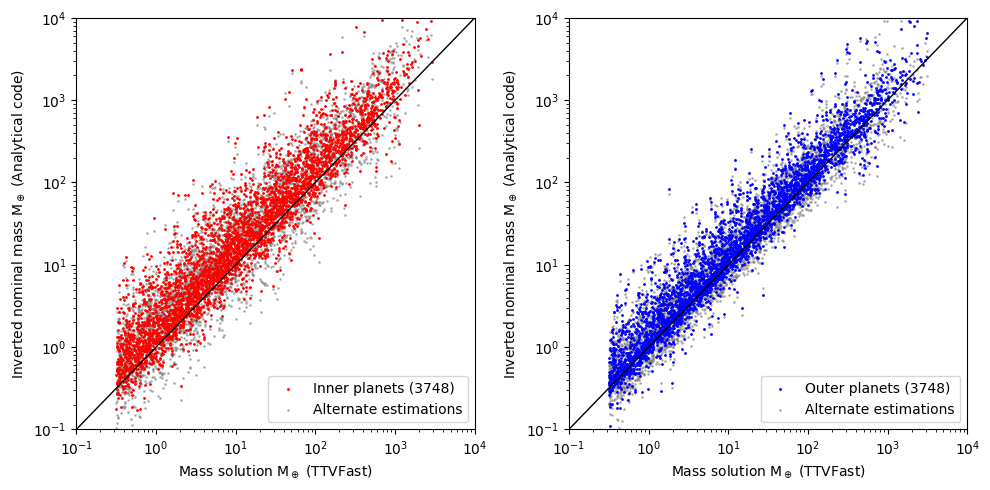

In [58]:
# Graph compare N-body outputs
fig, ax = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 2 columns
s = 1
minval = 1e-1
maxval = 1e+4

scatterCount = len(compare_n['m1'])

# Inner planets
ax[0].scatter(compare_n['m1'], compare_n['m_calc_in'], s=s, color='red', label=f'Inner planets ({scatterCount})', zorder=0)
ax[0].scatter(compare_n['m1'], compare_n['m_bad_in'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[0].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[0].set_xscale('log'); ax[0].set_yscale('log')
ax[0].set_xlim(minval, maxval); ax[0].set_ylim(minval, maxval)
ax[0].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[0].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[0].legend(loc='lower right')

# Outer planets
ax[1].scatter(compare_n['m2'], compare_n['m_calc_out'], s=s, color='blue', label=f'Outer planets ({scatterCount})', zorder=0)
ax[1].scatter(compare_n['m2'], compare_n['m_bad_out'], s=s, color='grey', label='Alternate estimations', zorder=-1, alpha=0.5)
ax[1].plot([minval, maxval], [minval, maxval], color='black', lw=1, zorder=1)
ax[1].set_xscale('log'); ax[1].set_yscale('log')
ax[1].set_xlim(minval, maxval); ax[1].set_ylim(minval, maxval)
ax[1].set_xlabel('Mass solution M$_\oplus$ (TTVFast)')
ax[1].set_ylabel('Inverted nominal mass M$_\oplus$ (Analytical code)')
ax[1].legend(loc='lower right')

fig.tight_layout()
plt.show()

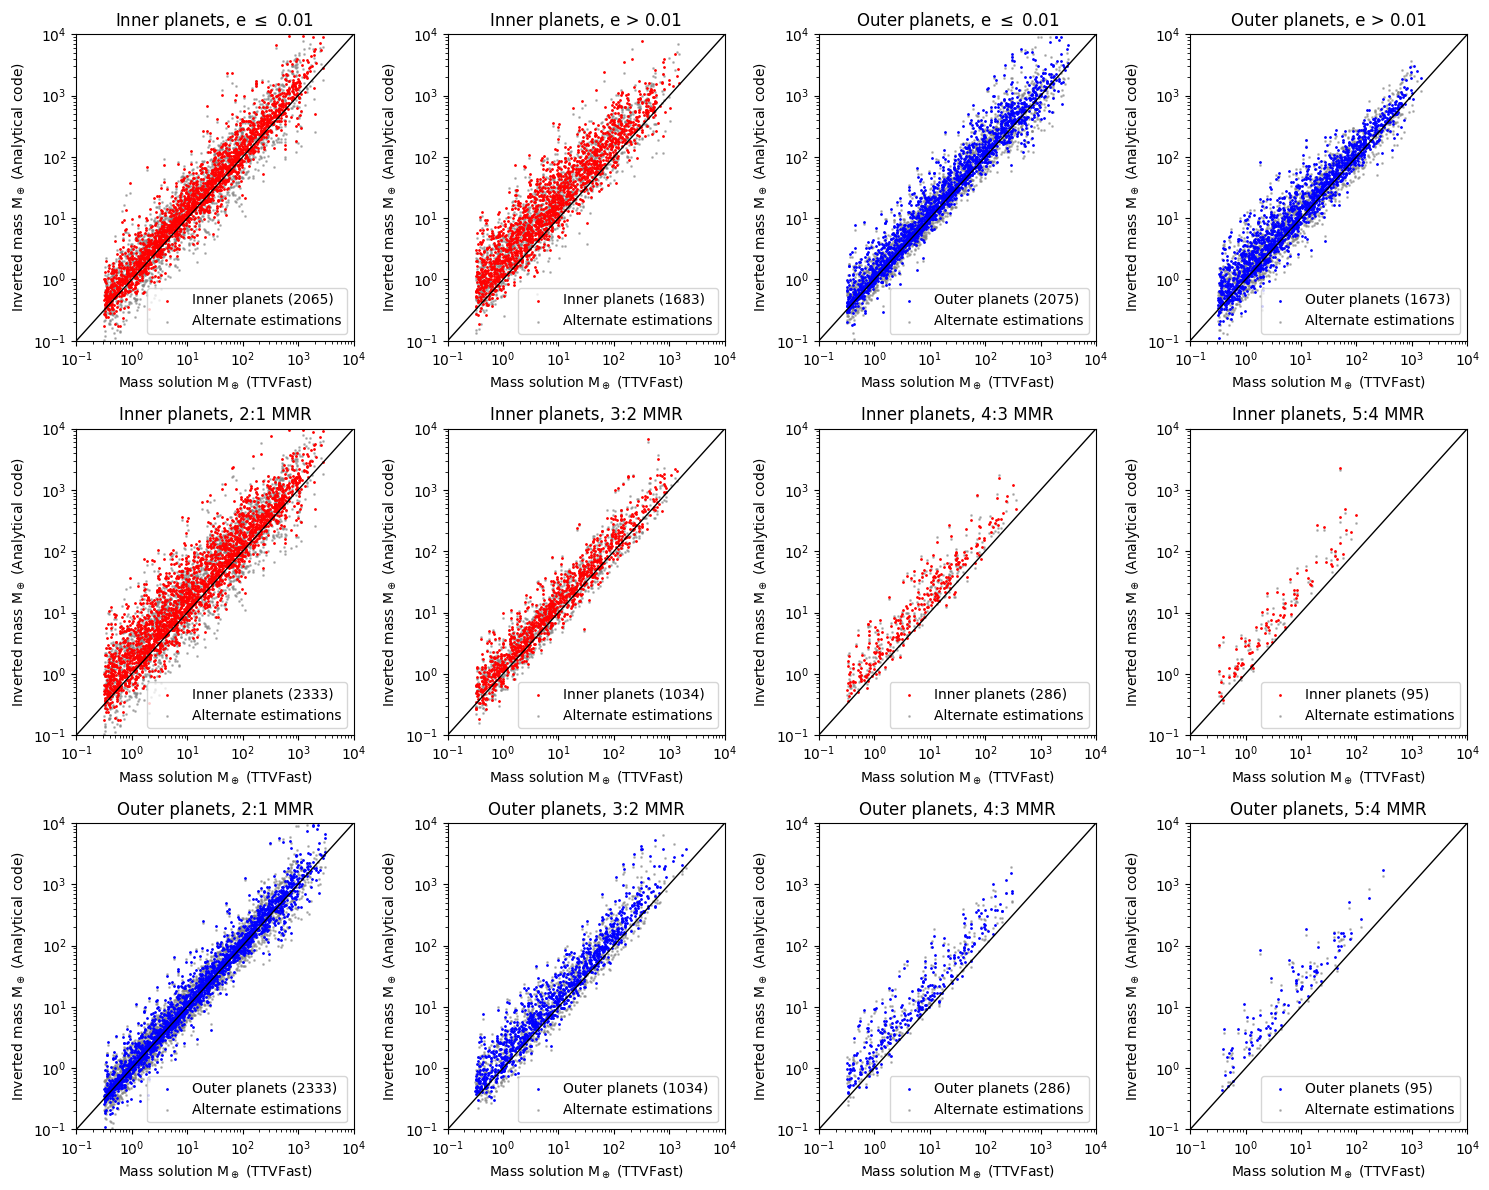

In [57]:
# Divide by regimes
fig, ax = plt.subplots(3, 4, figsize=(15, 12))
plotMassWithRegimes(compare_n)
fig.tight_layout()
plt.show()

In [91]:
# Relative bias and average error
err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare_n, mask='all')

print(f'Geometric mean error, median error, and geometric STD (Inner): {err1:.2f}%, {med1:.2f}%, {gstd1:.2f}%')
print(f'Geometric mean error, median error, and geometric STD (Outer): {err2:.2f}%, {med2:.2f}%, {gstd2:.2f}%')

Geometric mean error, median error, and geometric STD (Inner): 77.52%, 57.26%, 205.84%
Geometric mean error, median error, and geometric STD (Outer): 40.59%, 23.54%, 178.94%


# Metric compilation

In [92]:
# Metric summarized in dataframe
metricCols = ['regime', 'count', 'GMerr', 'GMerr_n', 'MedErr', 'MedErr_n', 'GSTDerr', 'GSTDerr_n']
metrics = pd.DataFrame(columns=metricCols)
metrics.regime = ['Inner (Overall)', 'Inner (e = 0.001-0.01)', 'Inner (e = 0.01-0.1)',
                  'Inner (2:1 MMR)', 'Inner (3:2 MMR)', 'Inner (4:3 MMR)', 'Inner (5:4 MMR)',
                  'Outer (Overall)', 'Outer (e = 0.001-0.01)', 'Outer (e = 0.01-0.1)',
                  'Outer (2:1 MMR)', 'Outer (3:2 MMR)', 'Outer (4:3 MMR)', 'Outer (5:4 MMR)']
metrics.head()

,regime,count,GMerr,GMerr_n,MedErr,MedErr_n,GSTDerr,GSTDerr_n
0,Inner (Overall),NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Inner (e = 0.001-0.01),NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Inner (e = 0.01-0.1),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Inner (2:1 MMR),NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Inner (3:2 MMR),NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [113]:
# Regime definitions
ethres = 0.01
lowe1 = (compare.e1 <= ethres); highe1 = (compare.e1 > ethres)
lowe2 = (compare.e2 <= ethres); highe2 = (compare.e2 > ethres)
def jmask(n): 
    return (compare.j == n)

# Create values to insert
def createListToInsert(innerOuterStr, m):
    err1, err2, med1, med2, gstd1, gstd2 = returnMetrics(compare, mask=m)
    err1n, err2n, med1n, med2n, gstd1n, gstd2n = returnMetrics(compare_n, mask=m)

    if innerOuterStr == 'Inner':
        metrics = [err1, err1n, med1, med1n, gstd1, gstd1n]
    elif innerOuterStr == 'Outer':
        metrics = [err2, err2n, med2, med2n, gstd2, gstd2n]

    count = len(compare.m1) if (isinstance(m, str) == True) else len(compare.m1[m])
    return [count, *metrics]

rows = []
for io in ['Inner', 'Outer']:
    for regime in ['all', 'lowe', 'highe', *[jmask(n) for n in range(2,6)]]:
        r = regime
        if isinstance(r, str):
            r = lowe1 if (regime == 'lowe') and (io == 'Inner') else r
            r = lowe2 if (regime == 'lowe') and (io == 'Outer') else r
            r = highe1 if (regime == 'highe') and (io == 'Inner') else r
            r = highe2 if (regime == 'highe') and (io == 'Outer') else r
        rowi = createListToInsert(io, m=r)
        rows.append(rowi)

# Inserting time
for i, r in enumerate(rows):
    metrics.loc[i, metricCols[1:]] = r

metrics

,regime,count,GMerr,GMerr_n,MedErr,MedErr_n,GSTDerr,GSTDerr_n
0,Inner (Overall),3748,19.665984,77.522369,8.302839,57.257319,168.241351,205.839729
1,Inner (e = 0.001-0.01),2065,25.641423,43.414418,15.7218,34.176259,173.320647,184.590351
2,Inner (e = 0.01-0.1),1683,12.721121,130.645496,3.813378,107.889299,160.711484,213.497804
3,Inner (2:1 MMR),2333,17.612469,82.182784,7.082828,55.5592,172.906494,221.809457
4,Inner (3:2 MMR),1034,17.875523,53.965055,7.922831,44.223065,157.796103,170.170817
5,Inner (4:3 MMR),286,36.046699,113.723368,20.122432,86.91455,158.977189,180.212366
6,Inner (5:4 MMR),95,46.589388,153.050969,24.849718,119.698749,173.204162,186.621774
7,Outer (Overall),3748,11.88904,40.592978,4.339695,23.535321,152.814804,178.939168
8,Outer (e = 0.001-0.01),2075,16.064544,37.64469,6.879511,19.286496,162.417,177.130219
9,Outer (e = 0.01-0.1),1673,6.918307,44.337586,1.593913,29.105383,138.776672,180.974434


In [112]:
# Export metrics
metrics.to_csv('lithwick_code_metrics.csv', index=False)

In [210]:
# Plot visualization
inner = metrics[0:7]; outer = metrics[7:14]

def metricPlots(df, innerOuterStr):
    regimenames = ['Overall', 'low e', 'high e', '2:1', '3:2', '4:3', '5:4']
    colnames = ['Regime', 'Count', 'Geometric Mean Error [%]', 'Geometric Mean Error (Nominal) [%]',
                'Median Error [%]', 'Median Error (Nominal) [%]', 'Geometric STD Error [%]', 'Geometric STD Error (Nominal) [%]']
    axposes = [(n,m) for n in range(3) for m in range(2)]
    
    df.loc[:, 'regime'] = regimenames
    df.columns = colnames
    
    fig, ax = plt.subplots(3, 2, figsize=(10, 12))
    x = 'Regime'
    colors = ['black', *['seagreen'] * 2, *['darkorange'] * 4]
    
    for col, axpos in zip(colnames[2:8], axposes):    
        barplot = sns.barplot(data=df, x=x, y=col, ax=ax[axpos])
        # ax[axpos].axhline(10, color='red', linestyle='--')
        # ax[axpos].axhline(100, color='red', linestyle='-')

        ys = []
        for patch, color in zip(barplot.patches, colors):
            patch.set_facecolor(color)
            height = patch.get_height()
            ys.append(height)
            
            ax[axpos].text(
                x=patch.get_x() + patch.get_width()/2,  # center of the bar
                y=height * 1.01,           # slightly above bar
                s=f'{height:.1f}',         # text to display
                ha='center', va='bottom'
            )
            
        ax[axpos].set_ylim(0, max(ys) * 1.1)
        ax[axpos].set_xlabel(f'Regime ({innerOuterStr} planets)')
        
    plt.show()

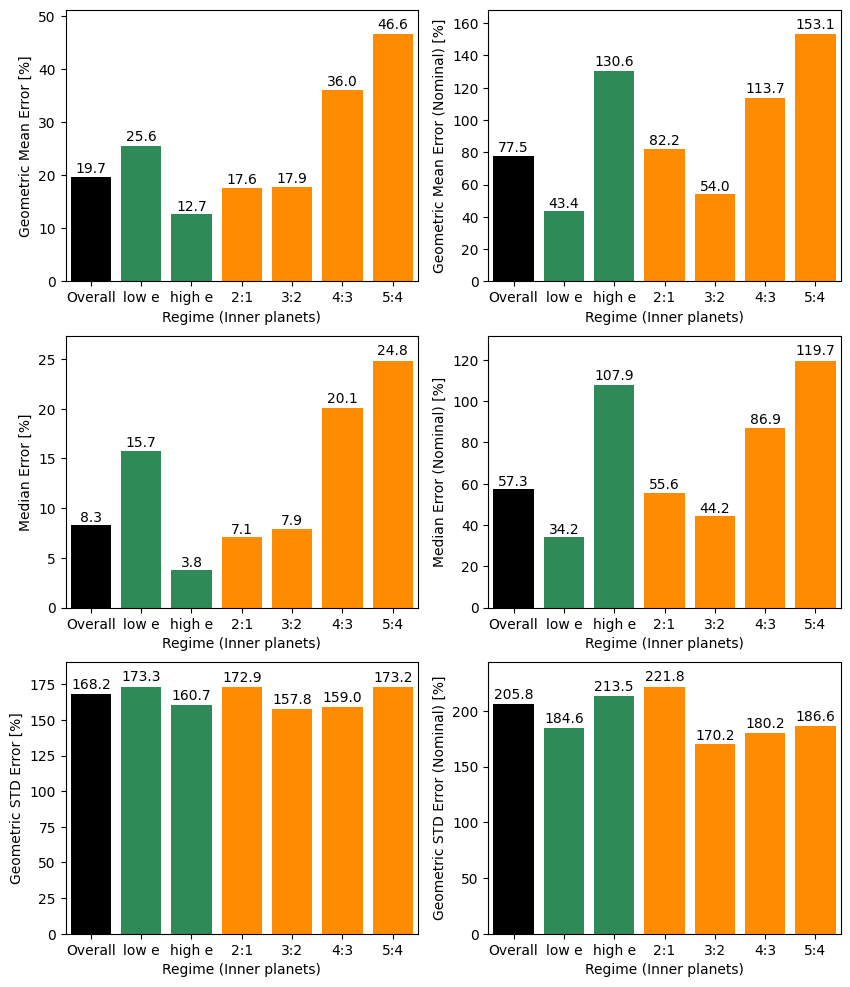

In [211]:
metricPlots(inner, 'Inner')

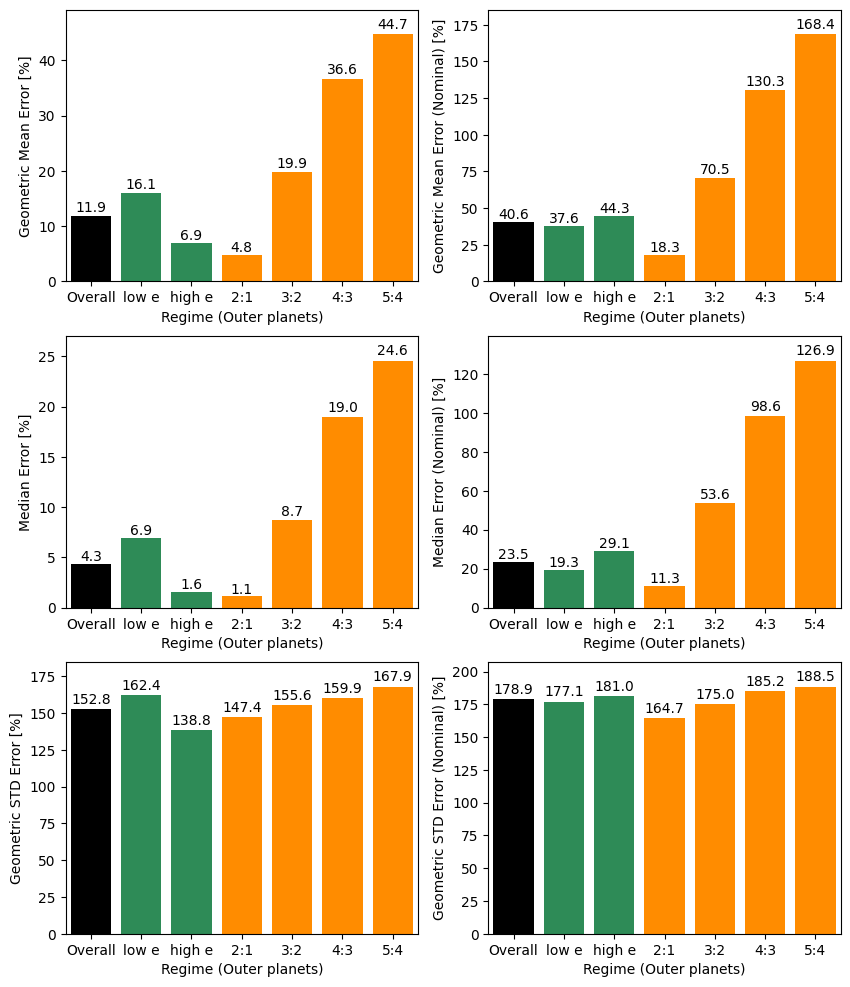

In [212]:
metricPlots(outer, 'Outer')